<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [54]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [55]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [56]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [57]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [58]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [59]:
# Posibles bandas
os.listdir("./songs_dataset/")

['dickinson.txt',
 'blink-182.txt',
 'britney-spears.txt',
 'adele.txt',
 'michael-jackson.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'bob-dylan.txt',
 'lady-gaga.txt',
 'r-kelly.txt',
 'missy-elliott.txt',
 'joni-mitchell.txt',
 'ludacris.txt',
 'jimi-hendrix.txt',
 'johnny-cash.txt',
 'bjork.txt',
 'bruce-springsteen.txt',
 'lorde.txt',
 'nickelback.txt',
 'nirvana.txt',
 'disney.txt',
 'nicki-minaj.txt',
 'nursery_rhymes.txt',
 'paul-simon.txt',
 'janisjoplin.txt',
 'patti-smith.txt',
 'cake.txt',
 'beatles.txt',
 'leonard-cohen.txt',
 'rihanna.txt',
 'bruno-mars.txt',
 'amy-winehouse.txt',
 'bieber.txt',
 'notorious-big.txt',
 'kanye.txt',
 'drake.txt',
 'lil-wayne.txt',
 'kanye-west.txt',
 'dolly-parton.txt',
 'bob-marley.txt',
 'notorious_big.txt',
 'radiohead.txt',
 'dr-seuss.txt',
 'eminem.txt',
 'lin-manuel-miranda.txt',
 'al-green.txt',
 'Kanye_West.txt',
 'Lil_Wayne.txt',
 'prince.txt']

In [60]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/lin-manuel-miranda.txt', sep='/n', header=None)
df.head()

/tmp/ipykernel_47359/9091060.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/lin-manuel-miranda.txt', sep='/n', header=None)


,0
0,"How does a bastard, orphan, son of a whore"
1,"And a Scotsman, dropped in the middle of a for..."
2,"In squalor, grow up to be a hero and a scholar..."
3,Got a lot farther by working a lot harder
4,By being a lot smarter By being a self-starter


In [61]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1084


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [62]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [63]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'How does a bastard, orphan, son of a whore'

In [64]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['how', 'does', 'a', 'bastard', 'orphan', 'son', 'of', 'a', 'whore']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [65]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [66]:
# Demos un vistazo
sentence_tokens[:2]

[['how', 'does', 'a', 'bastard', 'orphan', 'son', 'of', 'a', 'whore'],
 ['and',
  'a',
  'scotsman',
  'dropped',
  'in',
  'the',
  'middle',
  'of',
  'a',
  'forgotten',
  'spot',
  'in',
  'the',
  'caribbean',
  'by',
  'providence',
  'impoverished']]

In [67]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [68]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences

[['how', 'does', 'a', 'bastard'],
 ['does', 'a', 'bastard', 'orphan'],
 ['a', 'bastard', 'orphan', 'son'],
 ['bastard', 'orphan', 'son', 'of'],
 ['orphan', 'son', 'of', 'a']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [69]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [70]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[7, 5, 1, 2], [5, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 6], [3, 4, 6, 1]]

In [71]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

5


In [72]:
# Cantidad de palabras distintas
print(len(tok.word_counts))

7


In [73]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'a': 1, 'bastard': 2, 'orphan': 3, 'son': 4, 'does': 5, 'of': 6, 'how': 7}


In [74]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'how': 1, 'does': 2, 'bastard': 4, 'a': 4, 'orphan': 4, 'son': 3, 'of': 2})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [75]:
# Vistazo a las primeras filas
df.loc[:15,0]

0            How does a bastard, orphan, son of a whore
1     And a Scotsman, dropped in the middle of a for...
2     In squalor, grow up to be a hero and a scholar...
3             Got a lot farther by working a lot harder
4        By being a lot smarter By being a self-starter
5     By fourteen, they placed him in charge of a tr...
6     Across the waves, he struggled and kept his gu...
7     Inside, he was longing for something to be a p...
8     The brother was ready to beg, steal, borrow, o...
9     Our man saw his future drip, dripping down the...
10    Put a pencil to his temple, connected it to hi...
11    And he wrote his first refrain, a testament to...
12    Took up a collection just to send him to the m...
13    Get your education, don't forget from whence y...
14                And the world is gonna know your name
15            What's your name, man? Alexander Hamilton
Name: 0, dtype: object

In [76]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'How does a bastard, orphan, son of a whore And a Scotsman, dropped in the middle of a forgotten spot in the Caribbean by providence impoverished, In squalor, grow up to be a hero and a scholar? The ten-dollar founding father without a father Got a lot farther by working a lot harder By being a lot smarter By being a self-starter By fourteen, they placed him in charge of a trading charter And every day while slaves were being slaughtered and carted away Across the waves, he struggled and kept his guard up Inside, he was longing for something to be a part of The brother was ready to beg, steal, borrow, or barter Then a hurricane came, and devastation reigned Our man saw his future drip, dripping down the drain Put a pencil to his temple, connected it to his brain And he wrote his first refrain, a testament to his pain Well, the word got around, they said, this kid is insane, man Took up a collection just to send him to the mainland Get your education, don\'t forget from whence you came 

In [77]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['how',
 'does',
 'a',
 'bastard',
 'orphan',
 'son',
 'of',
 'a',
 'whore',
 'and',
 'a',
 'scotsman',
 'dropped',
 'in',
 'the',
 'middle',
 'of',
 'a',
 'forgotten',
 'spot']

In [78]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 11262


In [79]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [80]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['how', 'does', 'a', 'bastard'],
 ['does', 'a', 'bastard', 'orphan'],
 ['a', 'bastard', 'orphan', 'son'],
 ['bastard', 'orphan', 'son', 'of'],
 ['orphan', 'son', 'of', 'a'],
 ['son', 'of', 'a', 'whore'],
 ['of', 'a', 'whore', 'and'],
 ['a', 'whore', 'and', 'a'],
 ['whore', 'and', 'a', 'scotsman'],
 ['and', 'a', 'scotsman', 'dropped'],
 ['a', 'scotsman', 'dropped', 'in'],
 ['scotsman', 'dropped', 'in', 'the'],
 ['dropped', 'in', 'the', 'middle'],
 ['in', 'the', 'middle', 'of'],
 ['the', 'middle', 'of', 'a'],
 ['middle', 'of', 'a', 'forgotten'],
 ['of', 'a', 'forgotten', 'spot'],
 ['a', 'forgotten', 'spot', 'in'],
 ['forgotten', 'spot', 'in', 'the'],
 ['spot', 'in', 'the', 'caribbean']]

In [81]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[64, 309, 2, 468],
 [309, 2, 468, 219],
 [2, 468, 219, 310],
 [468, 219, 310, 12],
 [219, 310, 12, 2],
 [310, 12, 2, 469],
 [12, 2, 469, 5],
 [2, 469, 5, 2],
 [469, 5, 2, 470],
 [5, 2, 470, 471],
 [2, 470, 471, 11],
 [470, 471, 11, 1],
 [471, 11, 1, 378],
 [11, 1, 378, 12],
 [1, 378, 12, 2],
 [378, 12, 2, 472],
 [12, 2, 472, 172],
 [2, 472, 172, 11],
 [472, 172, 11, 1],
 [172, 11, 1, 473]]

In [82]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 11258


### 3 - Input y target

In [83]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [84]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [85]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [86]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(11258, 3)
(11258,)


In [87]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'a',
 3: 'i',
 4: 'you',
 5: 'and',
 6: 'to',
 7: 'for',
 8: "i'm",
 9: 'it',
 10: 'my',
 11: 'in',
 12: 'of',
 13: 'we',
 14: 'shot',
 15: 'your',
 16: 'wait',
 17: 'he',
 18: 'me',
 19: 'not',
 20: 'is',
 21: 'up',
 22: 'have',
 23: 'be',
 24: 'with',
 25: 'away',
 26: 'when',
 27: 'time',
 28: 'that',
 29: 'throwing',
 30: 'do',
 31: 'am',
 32: 'this',
 33: 'but',
 34: 'on',
 35: 'rise',
 36: 'his',
 37: 'if',
 38: 'can',
 39: 'are',
 40: 'what',
 41: 'gonna',
 42: 'new',
 43: 'like',
 44: 'hamilton',
 45: 'him',
 46: 'get',
 47: 'whoa',
 48: 'know',
 49: 'just',
 50: 'man',
 51: "it's",
 52: 'they',
 53: 'our',
 54: 'take',
 55: 'will',
 56: 'was',
 57: 'yo',
 58: 'no',
 59: 'every',
 60: 'so',
 61: 'sir',
 62: 'or',
 63: 'see',
 64: 'how',
 65: 'never',
 66: 'all',
 67: 'one',
 68: 'an',
 69: 'alexander',
 70: 'hey',
 71: 'takes',
 72: 'by',
 73: 'got',
 74: 'said',
 75: "don't",
 76: 'say',
 77: 'york',
 78: "'em",
 79: 'then',
 80: 'from',
 81: 'as',
 82: 'oh',
 8

In [88]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1549

In [89]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [90]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [91]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 1549


In [92]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 9007
Tamaño del conjunto de validacion: 2251


### 4 - Entrenar el modelo

In [93]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1549]                 --
├─Embedding: 1-1                         [1, 3, 5]                 7,750
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1549]                 51,117
├─Softmax: 1-6                           [1, 1549]                 --
Total params: 112,403
Trainable params: 112,403
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46

In [94]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 7.322 - Train accuracy 0.026 - Valid Loss 7.308 - Valid accuracy 0.039


Epoch: 2/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 3/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 4/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 5/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 6/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 7/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 8/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 9/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 10/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 11/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 12/100 - Train loss 7

/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_na

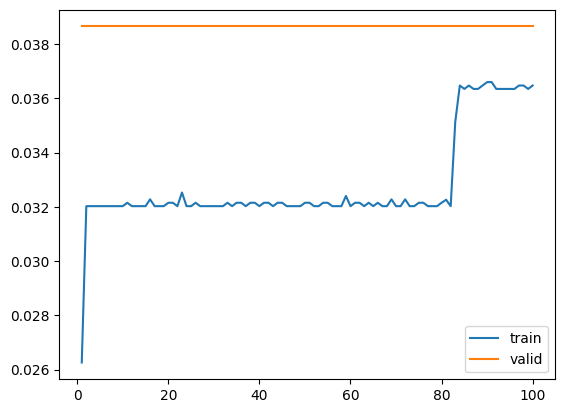

In [95]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

Claramente esta solucion no es muy util: en 100 epochs solo logra una minima mejora en la accuracy en training. Validation es igual a lo largo de todos el proceso

In [96]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 9007
Tamaño del conjunto de validacion: 2251


La primera modificacion es sumar mas embeddings

In [97]:
class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        embedding_dim =200
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1549]                 --
├─Embedding: 1-1                         [1, 3, 200]               310,000
├─LSTM: 1-2                              [1, 3, 64]                101,376
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1549]                 51,117
├─Softmax: 1-6                           [1, 1549]                 --
Total params: 464,573
Trainable params: 464,573
Non-trainable params: 0
Total mult-adds (M): 0.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.86
Estimated Total Size (MB): 1.88

In [98]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 7.325 - Train accuracy 0.023 - Valid Loss 7.311 - Valid accuracy 0.039
Epoch: 2/100 - Train loss 7.308 - Train accuracy 0.040 - Valid Loss 7.305 - Valid accuracy 0.041
Epoch: 3/100 - Train loss 7.292 - Train accuracy 0.055 - Valid Loss 7.302 - Valid accuracy 0.044
Epoch: 4/100 - Train loss 7.290 - Train accuracy 0.057 - Valid Loss 7.300 - Valid accuracy 0.047
Epoch: 5/100 - Train loss 7.280 - Train accuracy 0.070 - Valid Loss 7.295 - Valid accuracy 0.054
Epoch: 6/100 - Train loss 7.267 - Train accuracy 0.081 - Valid Loss 7.290 - Valid accuracy 0.057
Epoch: 7/100 - Train loss 7.263 - Train accuracy 0.084 - Valid Loss 7.292 - Valid accuracy 0.056
Epoch: 8/100 - Train loss 7.261 - Train accuracy 0.086 - Valid Loss 7.288 - Valid accuracy 0.059
Epoch: 9/100 - Train loss 7.260 - Train accuracy 0.086 - Valid Loss 7.289 - Valid accuracy 0.058
Epoch: 10/100 - Train loss 7.260 - Train accuracy 0.087 - Valid Loss 7.289 - Valid accuracy 0.057
Epoch: 11/100 - Train loss 7.

/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_na

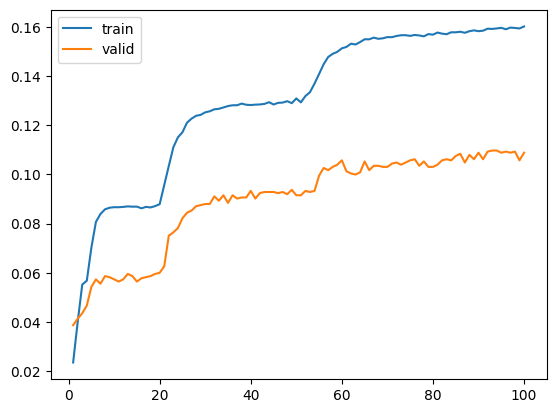

In [99]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

Es claro que hay una mejora sustancial en los resultados del proceso. Lo que aparece ahora es un claro escenario de overfitting. Una forma de reducir esto podria ser sumando mas neuronas en la capa de LSTM y haciendo que la misma sea bidireccional.

In [100]:
from torch.optim.lr_scheduler import StepLR

class Model3(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 128
        self.num_layers = 2
        embedding_dim = 200
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embedding_dim, padding_idx=0)
        # Use bidirectional LSTM
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2, bidirectional=True)  # Set bidirectional to True
        self.fc1 = nn.Linear(in_features=self.lstm_size * 2, out_features=32)  # Multiply lstm_size by 2 due to bidirectionality
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        
        # Concatenate the forward and backward LSTM outputs
        lstm_output = torch.cat((lstm_output[:, -1, :self.lstm_size], lstm_output[:, 0, self.lstm_size:]), dim=1)
        
        out = self.relu(self.fc1(lstm_output))
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers * 2, batch_size, self.lstm_size),  # Multiply num_layers by 2 due to bidirectionality
                torch.zeros(self.num_layers * 2, batch_size, self.lstm_size))

model3 = Model3(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model3_optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
model3_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# scheduler = StepLR(model3_optimizer, step_size=10, gamma=0.05)

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model3, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 1549]                 --
├─Embedding: 1-1                         [1, 3, 200]               310,000
├─LSTM: 1-2                              [1, 3, 256]               733,184
├─Linear: 1-3                            [1, 32]                   8,224
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1549]                 51,117
├─Softmax: 1-6                           [1, 1549]                 --
Total params: 1,102,525
Trainable params: 1,102,525
Non-trainable params: 0
Total mult-adds (M): 2.57
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.41
Estimated Total Size (MB): 4.43

In [101]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 9007
Tamaño del conjunto de validacion: 2251


In [102]:
history3 = train(model3,
                train_loader,
                valid_loader,
                model3_optimizer,
                model3_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 7.322 - Train accuracy 0.029 - Valid Loss 7.322 - Valid accuracy 0.024
Epoch: 2/100 - Train loss 7.315 - Train accuracy 0.032 - Valid Loss 7.309 - Valid accuracy 0.040
Epoch: 3/100 - Train loss 7.315 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 4/100 - Train loss 7.314 - Train accuracy 0.032 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 5/100 - Train loss 7.313 - Train accuracy 0.033 - Valid Loss 7.300 - Valid accuracy 0.047
Epoch: 6/100 - Train loss 7.313 - Train accuracy 0.034 - Valid Loss 7.300 - Valid accuracy 0.047
Epoch: 7/100 - Train loss 7.310 - Train accuracy 0.037 - Valid Loss 7.299 - Valid accuracy 0.047
Epoch: 8/100 - Train loss 7.308 - Train accuracy 0.039 - Valid Loss 7.297 - Valid accuracy 0.050
Epoch: 9/100 - Train loss 7.309 - Train accuracy 0.037 - Valid Loss 7.298 - Valid accuracy 0.049
Epoch: 10/100 - Train loss 7.308 - Train accuracy 0.038 - Valid Loss 7.303 - Valid accuracy 0.044
Epoch: 11/100 - Train loss 7.

/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_na

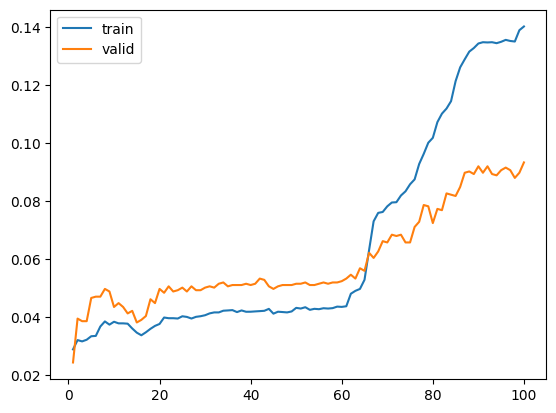

In [103]:
epoch_count = range(1, len(history3['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history3['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history3['val_accuracy'], label='valid')
plt.show()

Otra vez una mejora sustancial pero una tendencia incluso mas fuerta el overfitting. Una prueba valida podria ser sumar mas neuronas a las capas fully connected.

In [104]:
from torch.optim.lr_scheduler import StepLR

class Model4(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 128
        self.num_layers = 2
        embedding_dim = 200
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embedding_dim, padding_idx=0)
        # Use bidirectional LSTM
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2, bidirectional=True)  # Set bidirectional to True
        self.fc1 = nn.Linear(in_features=self.lstm_size * 2, out_features=32*2)  # Multiply lstm_size by 2 due to bidirectionality
        self.fc2 = nn.Linear(in_features=32*2, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        
        # Concatenate the forward and backward LSTM outputs
        lstm_output = torch.cat((lstm_output[:, -1, :self.lstm_size], lstm_output[:, 0, self.lstm_size:]), dim=1)
        
        out = self.relu(self.fc1(lstm_output))
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers * 2, batch_size, self.lstm_size),  # Multiply num_layers by 2 due to bidirectionality
                torch.zeros(self.num_layers * 2, batch_size, self.lstm_size))

model4 = Model4(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model4_optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)
model4_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# scheduler = StepLR(model3_optimizer, step_size=10, gamma=0.05)

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model4, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model4                                   [1, 1549]                 --
├─Embedding: 1-1                         [1, 3, 200]               310,000
├─LSTM: 1-2                              [1, 3, 256]               733,184
├─Linear: 1-3                            [1, 64]                   16,448
├─ReLU: 1-4                              [1, 64]                   --
├─Linear: 1-5                            [1, 1549]                 100,685
├─Softmax: 1-6                           [1, 1549]                 --
Total params: 1,160,317
Trainable params: 1,160,317
Non-trainable params: 0
Total mult-adds (M): 2.63
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.64
Estimated Total Size (MB): 4.67

In [105]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 9007
Tamaño del conjunto de validacion: 2251


In [106]:
history4 = train(model4,
                train_loader,
                valid_loader,
                model4_optimizer,
                model4_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 7.321 - Train accuracy 0.028 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 2/100 - Train loss 7.314 - Train accuracy 0.034 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 3/100 - Train loss 7.307 - Train accuracy 0.039 - Valid Loss 7.317 - Valid accuracy 0.028
Epoch: 4/100 - Train loss 7.307 - Train accuracy 0.039 - Valid Loss 7.309 - Valid accuracy 0.037
Epoch: 5/100 - Train loss 7.301 - Train accuracy 0.045 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 6/100 - Train loss 7.299 - Train accuracy 0.048 - Valid Loss 7.306 - Valid accuracy 0.040
Epoch: 7/100 - Train loss 7.292 - Train accuracy 0.054 - Valid Loss 7.308 - Valid accuracy 0.039
Epoch: 8/100 - Train loss 7.289 - Train accuracy 0.058 - Valid Loss 7.305 - Valid accuracy 0.041
Epoch: 9/100 - Train loss 7.285 - Train accuracy 0.062 - Valid Loss 7.299 - Valid accuracy 0.048
Epoch: 10/100 - Train loss 7.266 - Train accuracy 0.081 - Valid Loss 7.295 - Valid accuracy 0.052
Epoch: 11/100 - Train loss 7.

/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_natural/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodrigo/projects/posgrado/procesamiento_lenguaje_na

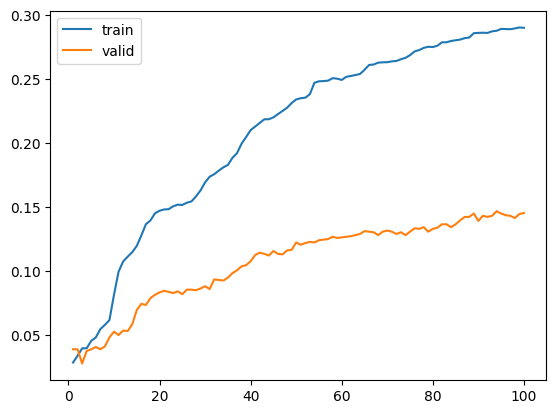

In [110]:
epoch_count = range(1, len(history4['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history4['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history4['val_accuracy'], label='valid')
plt.show()

Otra vez se logra un mejor resultado en terminos de validation en la misma cantidad de epochs pero se profundiza incluso mas el problema de overfitting.

__Es importante__ destacar que en este ejemplo estamos entrenando nuestro propios Embeddings y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

Una capa de embeddings mas grande parece arrojar mejores resultados en terminos de accuracy y un nivel incluso mayor de overfitting.

### 5 - Generación de secuencias nuevas

In [108]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

A partir de los modelos obtenidos se realizaran algunas pruebas, de forma de demostrar como fueron cambiando con los diferentes cambios.

Al igual que para el TP anterior se utilizo el dataset del musical Hamilton. En funcion a eso se podria esperar 1) algun tipo de prevalencia de las repeticiones que aparen en varias canciones ("I am not throwing away my shot" como prueba para este caso) 2) alguna relacion con los personajes. Eso es lo que se va a probar

In [121]:
input_texts=['young scruffy and', "i am not", "throwing away my", "away my shot", "alexander hamilton", "george washington", "aaron burr", "thomas jefferson", "american experiment", "federalist papers"]

models = [model1, model2, model3, model4]

for text in input_texts:
    for i, model in enumerate(models):
        print(f"model {i+1}: {generate_seq(model3, tok, text, max_length=3, n_words=1)}")

model 1: young scruffy and and
model 2: young scruffy and and
model 3: young scruffy and the
model 4: young scruffy and and
model 1: i am not the
model 2: i am not the
model 3: i am not the
model 4: i am not the
model 1: throwing away my and
model 2: throwing away my and
model 3: throwing away my and
model 4: throwing away my and
model 1: away my shot a
model 2: away my shot a
model 3: away my shot a
model 4: away my shot a
model 1: alexander hamilton a
model 2: alexander hamilton a
model 3: alexander hamilton a
model 4: alexander hamilton a
model 1: george washington the
model 2: george washington the
model 3: george washington the
model 4: george washington and
model 1: aaron burr and
model 2: aaron burr i
model 3: aaron burr and
model 4: aaron burr and
model 1: thomas jefferson i
model 2: thomas jefferson i
model 3: thomas jefferson i
model 4: thomas jefferson i
model 1: american experiment and
model 2: american experiment and
model 3: american experiment and
model 4: american exper

Claramente todos los modelos hicieron "trampa": usaron palabras comunes en el habla inglesa como "my", "and", "a", "i" y "the". Eso es lo que durante el entrenamiento les permite mejorar su loss y su accuracy, haciendo predicciones triviales. Por otro lado, en general, la prediccion que hace tampoco es incorrecta, ya que en muchos casos es al menos gramaticalmente correcta. Pero probablemente esto sucede de casualidad: si se usaran inputs mas abstractos el se notaria lo poco apto de los modelos.

In [124]:
input_texts=['and the', "i am", "me and"]

models = [model1, model2, model3, model4]

for text in input_texts:
    for i, model in enumerate(models):
        print(f"model {i+1}: {generate_seq(model3, tok, text, max_length=3, n_words=1)}")

model 1: and the and
model 2: and the and
model 3: and the and
model 4: and the and
model 1: i am 
model 2: i am 
model 3: i am 
model 4: i am 
model 1: me and and
model 2: me and 
model 3: me and and
model 4: me and 


Claramente la respuesta de los modelos es responder trivialidades ante cualquier escenario. Eso le gana un nivel de accuracy que va mejorando en los entrenamientos pero que finalmente no es util. Esto demuestra que incluso mejorando la arquitectura propuesta inicialmente los modelos con embeddings no pre-entrenados no logran modelos utiles

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.